In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import keras
# from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#cpu - gpu configuration
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [0]:
#variables
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 32
epochs = 20

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Processing dataset

In [0]:
#read kaggle facial expression recognition challenge dataset (fer2013.csv)
#https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

with open("/content/gdrive/My Drive/WeekSeven/fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
instance length:  2304


In [0]:
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

In [0]:
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
	      print("",end="")


In [0]:
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

28709 train samples
3589 test samples


In [0]:
# Convert from 7 columns to 1 column
Y_train, Y_test = [], []
for i in range(y_train.shape[0]):
  for j in range(7):
    if 1 == y_train[i][j]:
      Y_train.append(j)

for i in range(y_test.shape[0]):
  for j in range(7):
    if 1 == y_test[i][j]:
      Y_test.append(j)  

Y_train = np.array(Y_train, 'float32')
Y_test = np.array(Y_test, 'float32')
Y_test.shape, Y_train.shape, Y_train[51], Y_test[101]  

((3589,), (28709,), 5.0, 6.0)

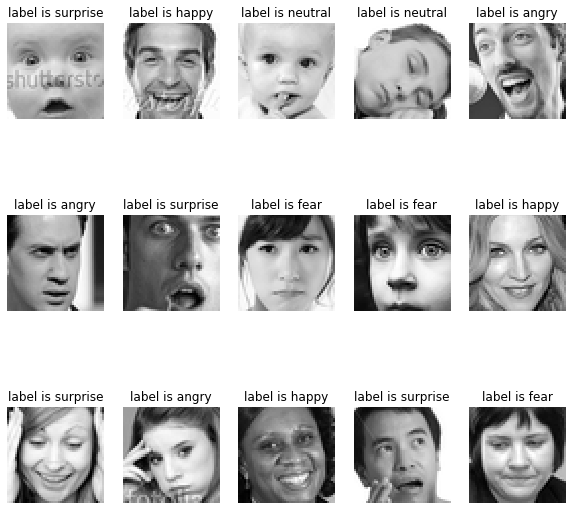

In [0]:
# Showing some images
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}

def show_batch():
    '''Show batch of 25 images.

    '''
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(3,5,n+1)
        num = np.random.randint(0,28709)
        plt.gray()
        plt.imshow(x_train[num].reshape([48, 48]))
        plt.title('label is '+labels[Y_train[num]])
        plt.axis('off')

show_batch()

## Modeling and Training

We tried a sequential model first

In [0]:
#construct CNN structure
def CNNd():
    model = tf.keras.models.Sequential([
            #1st convolution layer
            Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1),padding='same'),
            MaxPooling2D(pool_size=(5,5), strides=(2, 2)),
            BatchNormalization(),

            #2nd convolution layer
            Conv2D(128, (3, 3), activation='relu',padding='same'),
            Conv2D(128, (3, 3), activation='relu',padding='same'),
            AveragePooling2D(pool_size=(3,3), strides=(2, 2)),
            BatchNormalization(),

            #3rd convolution layer
            Conv2D(256, (3, 3), activation='relu',padding='same'),
            Conv2D(256, (3, 3), activation='relu',padding='same'),
            AveragePooling2D(pool_size=(3,3), strides=(2, 2)),
            BatchNormalization(),

            #4th convolution layer
            Conv2D(512, (3, 3), activation='relu',padding='same'),
            Conv2D(512, (3, 3), activation='relu',padding='same'),
            AveragePooling2D(pool_size=(3,3), strides=(2, 2)),
            BatchNormalization(),

            Flatten(),

            #fully connected neural networks
            Dense(4096, activation='relu'),
            Dropout(0.2),
            BatchNormalization(),

            Dense(1024, activation='relu'),
            Dropout(0.2),
            BatchNormalization(),

            Dense(num_classes, activation='softmax'),
            ])
    return model

modeld = CNNd()

In [0]:
#ImageDataGenerator for train
import math

gen = ImageDataGenerator()
train_generator = gen.flow(x_train, Y_train, batch_size=batch_size,shuffle=True)
test_generator = gen.flow(x_test, Y_test, batch_size=batch_size,shuffle=True)

num_steps_train = math.ceil(float(x_train.shape[0])/batch_size)
num_steps_val = math.ceil(float(x_test.shape[0])/batch_size)

In [0]:
#Compile model
modeld.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
#Fit model or load weights
fit = True

if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
	modeld.fit(train_generator, steps_per_epoch=num_steps_train, epochs=25, validation_data=test_generator, validation_steps=num_steps_val) #train for randomly selected one
else:
	modeld.load_weights('/data/facial_expression_model_weights.h5') #load weights

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 898 steps, validate for 113 steps
Epoch 1/25
898/898 [==============================] - 15s 16ms/step - loss: 2.0181 - accuracy: 0.2237 - val_loss: 1.8409 - val_accuracy: 0.2405
Epoch 2/25
898/898 [==============================] - 13s 14ms/step - loss: 1.8199 - accuracy: 0.2795 - val_loss: 1.8683 - val_accuracy: 0.2767
Epoch 3/25
898/898 [==============================] - 13s 14ms/step - loss: 1.6217 - accuracy: 0.3735 - val_loss: 2.1803 - val_accuracy: 0.2697
Epoch 4/25
898/898 [==============================] - 13s 14ms/step - loss: 1.4082 - accuracy: 0.4631 - val_loss: 1.4344 - val_accuracy: 0.4416
Epoch 5/25
898/898 [==============================] - 13s 14ms/step - loss: 1.2734 - accuracy: 0.5134 - val_loss: 1.3369 - val_accuracy: 0.4976
Epoch 6/25
898/898 [==============================] - 13s 14ms/step - loss: 1.1993 - accuracy: 0.5500 - val_loss: 1.2737 - val_accuracy: 0.5099
Epoch 7/25
898/898 [======================

In [0]:
modeld.save('/content/gdrive/My Drive/WeekSeven/emotiond.h5')

## Building model with HOG and face landmarks with Functional API

https://www.tensorflow.org/guide/keras/functional

- We don't use transfer learning because our dataset contains greyscale images and doesn't fit in 3 channel pretrained models.
- Our model achieved ~99% accuracy on train set and ~75% on validation set after 25 epochs (batch size 32)
- We use [this paper](https://arxiv.org/abs/1612.02903) as benchmark which achieves 75.2% accuracy. 
- The two tables below show training result on 5 expressions done by [amineHorseman](https://github.com/amineHorseman/facial-expression-recognition-using-cnn). It shows that face landmarks and histogram of oriented gradients (HOG) only improves the accuracy by 4.5% at best. On the other hand, batch normalization significantly improves the model performance.
![](https://i.imgur.com/F5JF0io.png)
![](https://i.imgur.com/49AbN0v.png)
-    Using example code extract face landmarks using dlib shape predictor model
-    Example code get hog features using scikit image hog
-    Using functional API https://www.tensorflow.org/guide/keras/functional

In [0]:
from tensorflow import keras
from tensorflow.keras import layers

#construct CNN structure
def CNNhogLandmark():
    img_input = keras.Input(shape=(48,48, 1), name='img')
    #1st convolution layer
    x = layers.Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1),padding='same')(img_input)
    x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
    output_1st = layers.BatchNormalization()(x)

    #2nd convolution layer
    x = layers.Conv2D(128, (3, 3), activation='relu',padding='same')(output_1st)
    x = layers.Conv2D(128, (3, 3), activation='relu',padding='same')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    output_2nd = layers.BatchNormalization()(x)

    #3rd convolution layer
    x = layers.Conv2D(256, (3, 3), activation='relu',padding='same')(output_2nd)
    x = layers.Conv2D(256, (3, 3), activation='relu',padding='same')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    output_3rd = layers.BatchNormalization()(x)

    #4th convolution layer
    x = layers.Conv2D(512, (3, 3), activation='relu',padding='same')(output_3rd)
    x = layers.Conv2D(512, (3, 3), activation='relu',padding='same')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    output_4th = layers.BatchNormalization()(x)

    flat = layers.Flatten()(output_4th)

    #fully connected neural networks
    fc1 = layers.Dense(4096, activation='relu')(flat)
    fc1 = layers.Dropout(0.2)(fc1)
    fc1 = layers.BatchNormalization()(fc1)

    fc2 = layers.Dense(1024, activation='relu')(fc1)
    fc2 = layers.Dropout(0.2)(fc2)
    fc2 = layers.BatchNormalization()(fc2)

    #Hog and landmark input
    hog_landmark_input = keras.Input(shape=(2728), name='hog_landmark')
    
    hl_network = layers.Dense(1024, activation='relu')(hog_landmark_input)
    hl_network = layers.BatchNormalization()(hl_network)

    # Merge all available features into a single large vector via concatenation
    x = layers.concatenate([fc2, hl_network])

    # Stick a logistic regression for prediction on top of the features
    out = layers.Dense(num_classes, activation='softmax')(x)
    
    # Instantiate an end-to-end model predicting 
    final = keras.Model(inputs=[img_input, hog_landmark_input],
                        outputs=[out])
    return final

modelhl = CNNhogLandmark()

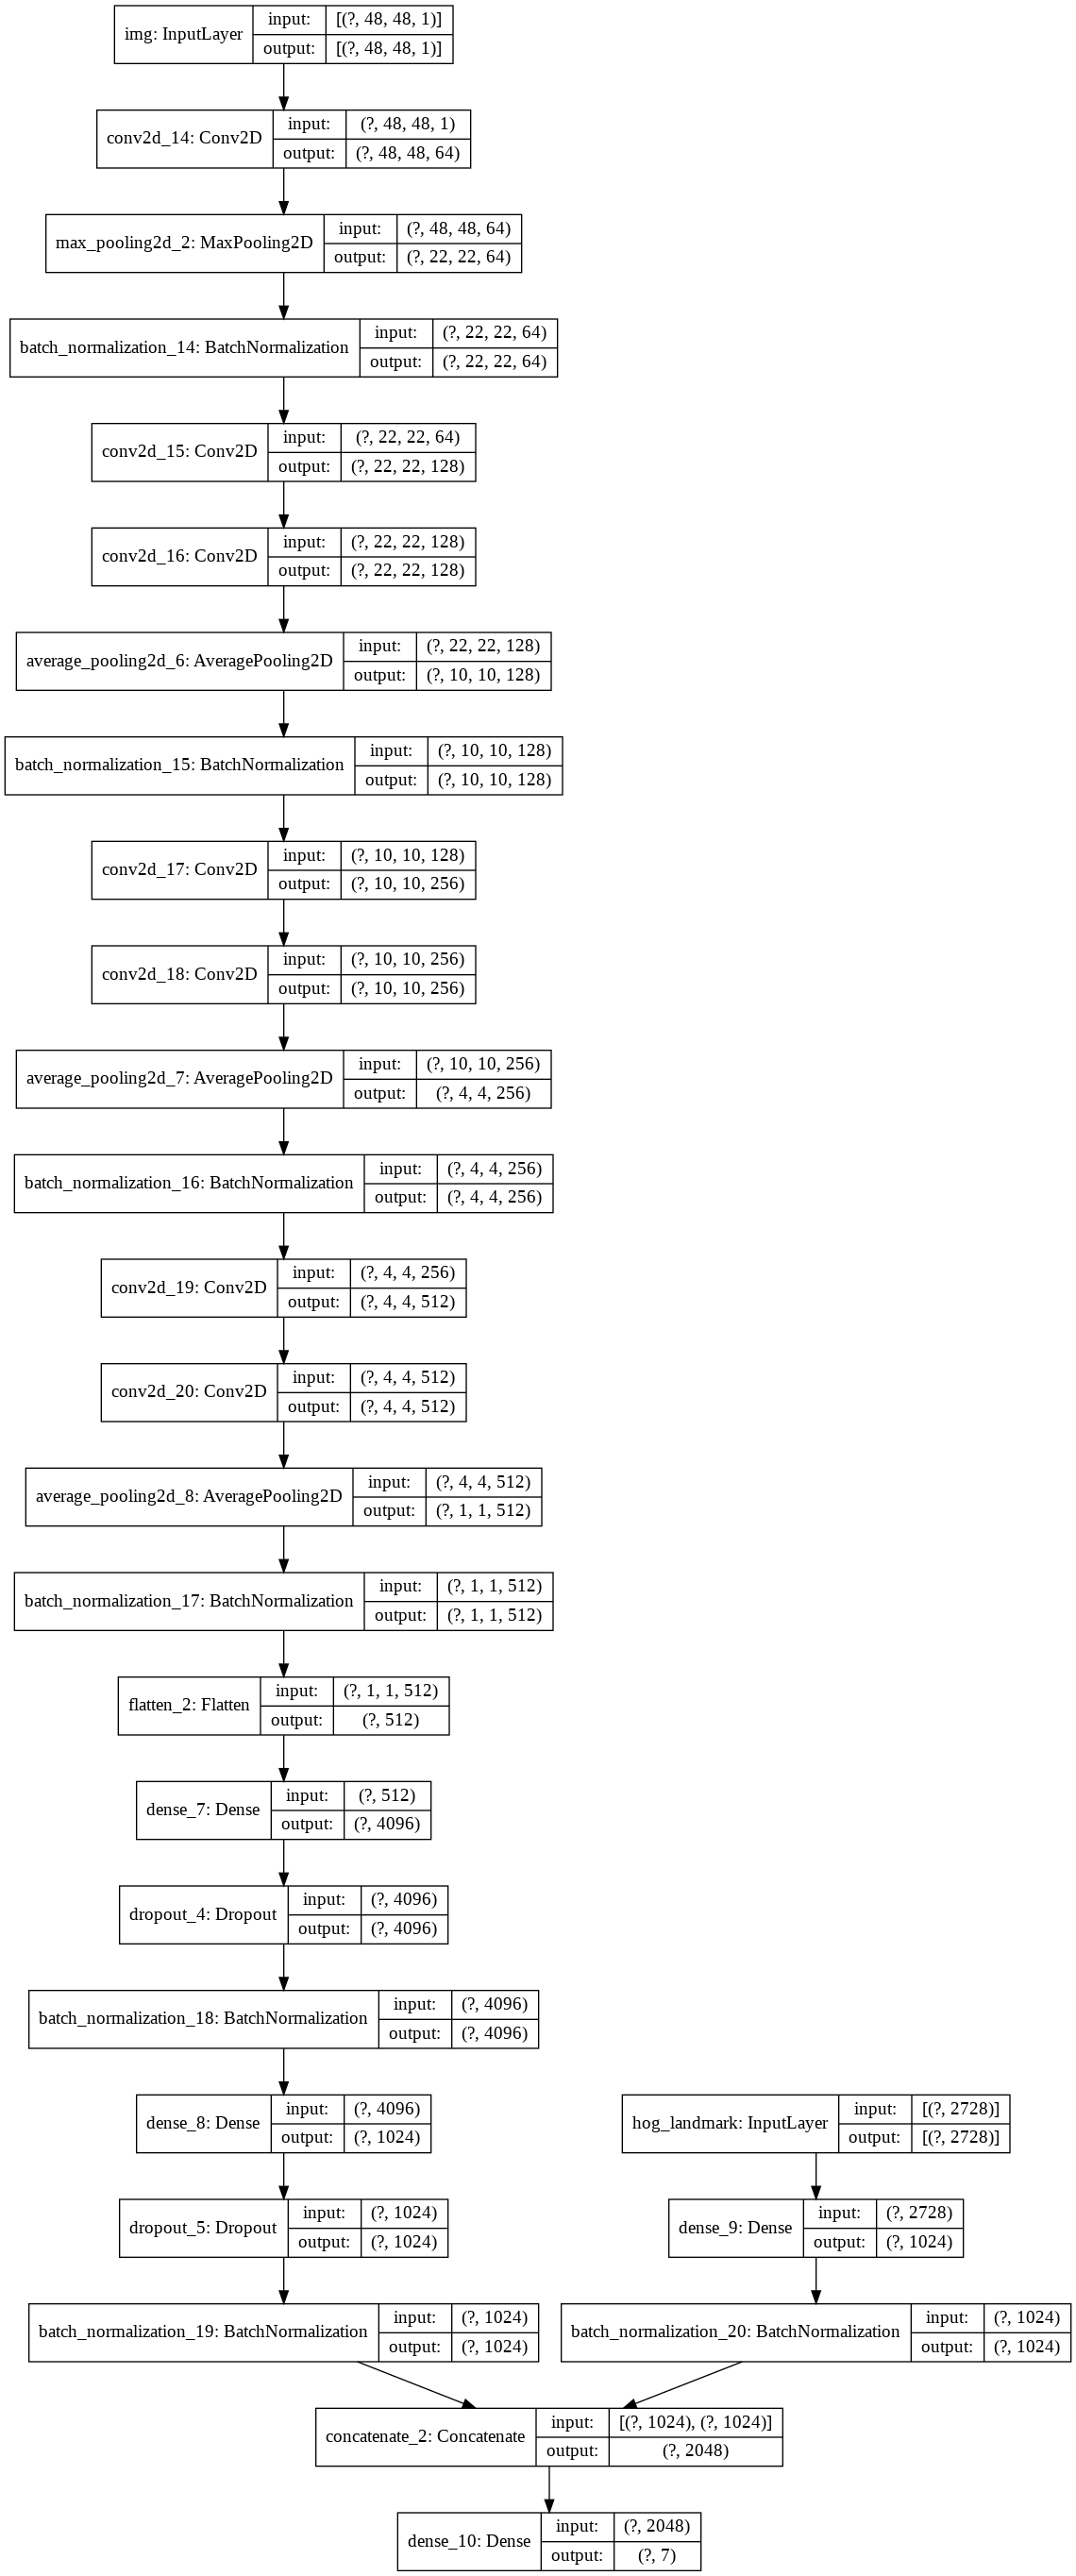

In [0]:
keras.utils.plot_model(modelhl, 'multi_input_CNNhogLandmark.png', show_shapes=True)


In [0]:
#Compile model
modelhl.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Get HOG Histogram of oriented gradients and landmarks
![](https://iq.opengenus.org/content/images/2019/07/hog-vis.png)
![](https://iq.opengenus.org/content/images/2019/07/hog1.png)


```PYTHON=
#get HOG Histogram of oriented gradients
from skimage.feature import hog

def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, image_height, window_step):
        for x in range(0, image_width, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualize=False))
    return hog_windows

hog_features = []
if GET_HOG_WINDOWS_FEATURES:
                    features = sliding_hog_windows(image)
                    f, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                            cells_per_block=(1, 1), visualize=True)
                    hog_features.append(features)
```

![](https://www.pyimagesearch.com/wp-content/uploads/2017/04/facial_landmarks_68markup-1024x825.jpg)
![](https://www.pyimagesearch.com/wp-content/uploads/2017/04/facial_landmarks_example_03_result.jpg)
```PYTHON=
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

landmarks = []

def get_landmarks(image, rects):
    # this function have been copied from http://bit.ly/2cj7Fpq
    if len(rects) > 1:
        raise BaseException("TooManyFaces")
    if len(rects) == 0:
        raise BaseException("NoFaces")
    return np.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

if GET_LANDMARKS:
                    # matplotlib.image.imsave('temp.jpg', image)
                    # imageio.imwrite('temp.jpg', image)
                    # im = Image.fromarray(image)
                    # im.save('temp.jpg')
                    cv2.imwrite('temp.jpg',image)
                    image2 = cv2.imread('temp.jpg')
                    face_rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]
                    face_landmarks = get_landmarks(image2, face_rects)
                    landmarks.append(face_landmarks)            
```

In [0]:
#Load HOG and landmark
data_dict = {}
val_dict = {}
#Load image data
data_dict['X'] = np.load('/content/gdrive/My Drive/My_CoderSchool/WeekSeven/Project/fer2013_features_v1/Training/images.npy')
data_dict['X'] = data_dict['X'].reshape([-1, 48, 48, 1])
data_dict['Y'] = np.load('/content/gdrive/My Drive/My_CoderSchool/WeekSeven/Project/fer2013_features_v1/Training/labels.npy')
        
#Load hog and landmark
data_dict['X2'] = np.load('/content/gdrive/My Drive/My_CoderSchool/WeekSeven/Project/fer2013_features_v1/Training/landmarks.npy')
data_dict['X2'] = np.array([x.flatten() for x in data_dict['X2']])
data_dict['X2'] = np.concatenate((data_dict['X2'], np.load('/content/gdrive/My Drive/My_CoderSchool/WeekSeven/Project/fer2013_features_v1/Training/hog_features.npy')), axis=1)

#Load validation data
val_dict['X'] = np.load('/content/gdrive/My Drive/My_CoderSchool/WeekSeven/Project/fer2013_features_v1/PublicTest/images.npy')
val_dict['X'] = val_dict['X'].reshape([-1, 48, 48, 1])
val_dict['Y'] = np.load('/content/gdrive/My Drive/My_CoderSchool/WeekSeven/Project/fer2013_features_v1/PublicTest/labels.npy')

val_dict['X2'] = np.load('/content/gdrive/My Drive/My_CoderSchool/WeekSeven/Project/fer2013_features_v1/PublicTest/landmarks.npy')
val_dict['X2'] = np.array([x.flatten() for x in val_dict['X2']])
val_dict['X2'] = np.concatenate((val_dict['X2'], np.load('/content/gdrive/My Drive/My_CoderSchool/WeekSeven/Project/fer2013_features_v1/PublicTest/hog_features.npy')), axis=1)
val_dict['Y'] = np.load('/content/gdrive/My Drive/My_CoderSchool/WeekSeven/Project/fer2013_features_v1/PublicTest/labels.npy')

data_dict['X'].shape, data_dict['Y'].shape, data_dict['X2'].shape, val_dict['X'].shape, val_dict['Y'].shape, val_dict['X2'].shape

((3436, 48, 48, 1),
 (3436, 7),
 (3436, 2728),
 (56, 48, 48, 1),
 (56, 7),
 (56, 2728))

In [0]:
# Convert from 7 columns to 1 column
Y_train_c, Y_test_c = [], []
for i in range(data_dict['Y'].shape[0]):
  for j in range(7):
    if 1 == data_dict['Y'][i][j]:
      Y_train_c.append(j)

for i in range(val_dict['Y'].shape[0]):
  for j in range(7):
    if 1 == val_dict['Y'][i][j]:
      Y_test_c.append(j)  

Y_train_c = np.array(Y_train_c, 'float32')
Y_test_c = np.array(Y_test_c, 'float32')
Y_test_c.shape, Y_train_c.shape, Y_train_c[51], Y_test_c[45]  

((56,), (3436,), 5.0, 1.0)

In [0]:
# Seeing the number of each class in train and test set
unique_train, counts_train = np.unique(Y_train_c, return_counts=True)
unique_test, counts_test = np.unique(Y_test_c, return_counts=True)
dict(zip(unique_train, counts_train)), dict(zip(unique_test, counts_test))

({0.0: 500, 1.0: 436, 2.0: 500, 3.0: 500, 4.0: 500, 5.0: 500, 6.0: 500},
 {1.0: 56})

In [0]:
#ImageDataGenerator for train


# gen = ImageDataGenerator()
# train_generator_img = gen.flow(data_dict['X'], Y_train, batch_size=batch_size,shuffle=True)
# test_generator_img = gen.flow(x_test, Y_test, batch_size=batch_size,shuffle=True)



In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['accuracy'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()

def plot_stats(training_stats, val_stats, x_label='Training Steps', stats='loss'):
    stats, x_label = stats.title(), x_label.title()
    legend_loc = 'upper right' if stats=='loss' else 'lower right'
    training_steps = len(training_stats)
    test_steps = len(val_stats)

    plt.figure()
    plt.ylabel(stats)
    plt.xlabel(x_label)
    plt.plot(training_stats, label='Training ' + stats)
    plt.plot(np.linspace(0, training_steps, test_steps), val_stats, label='Validation ' + stats)
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc=legend_loc)
    plt.show()

batch_stats_callback = CollectBatchStats()

In [0]:
# import math
# num_steps_train = math.ceil(float(data_dict['X'].shape[0])/batch_size)
# num_steps_val = math.ceil(float(val_dict['X'].shape[0])/batch_size)

modelhl.fit(x={'img': data_dict['X'], 'hog_landmark': data_dict['X2']},
            y=Y_train_c,
            epochs=21,
            callbacks=[batch_stats_callback],
            validation_data=({'img': val_dict['X'], 'hog_landmark': val_dict['X2']},Y_test_c))

            # steps_per_epoch=num_steps_train, 
            # validation_steps=num_steps_val) 
            

Train on 3436 samples, validate on 56 samples
Epoch 1/21
3436/3436 [==============================] - 2s 622us/sample - loss: 2.2742 - accuracy: 0.4167 - val_loss: 1.5381 - val_accuracy: 0.0417
Epoch 2/21
3436/3436 [==============================] - 2s 566us/sample - loss: 1.8438 - accuracy: 0.3333 - val_loss: 0.6750 - val_accuracy: 0.8750
Epoch 3/21
3436/3436 [==============================] - 2s 552us/sample - loss: 1.6173 - accuracy: 0.5000 - val_loss: 1.2003 - val_accuracy: 0.7500
Epoch 4/21
3436/3436 [==============================] - 2s 558us/sample - loss: 1.4631 - accuracy: 0.5833 - val_loss: 1.0099 - val_accuracy: 0.7500
Epoch 5/21
3436/3436 [==============================] - 2s 557us/sample - loss: 1.3418 - accuracy: 0.5833 - val_loss: 0.8021 - val_accuracy: 0.7500
Epoch 6/21
3436/3436 [==============================] - 2s 557us/sample - loss: 1.2253 - accuracy: 0.3333 - val_loss: 1.0243 - val_accuracy: 0.7083
Epoch 7/21
3436/3436 [==============================] - 2s 558us/s

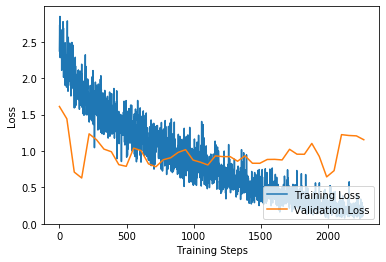

In [0]:
plot_stats(batch_stats_callback.batch_losses, batch_stats_callback.batch_val_losses, stats='loss')

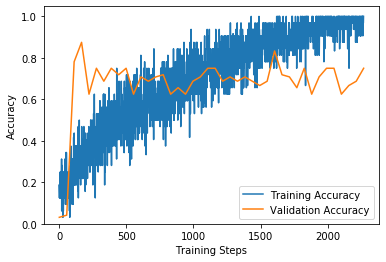

In [0]:
plot_stats(batch_stats_callback.batch_acc, batch_stats_callback.batch_val_acc, stats='accuracy')

In [0]:
modelhl.save('/content/gdrive/My Drive/My_CoderSchool/WeekSeven/Project/hog_landmark_sliding.h5')

We have very good train (100%) and validation (75%) accuracy but our dataset is too small. I will try to improve by augmenting numpy arrays.

## Testing with google image downloader and other dataset

In [0]:
!pip install google_images_download

     |████████████████████████████████| 911kB 52.8MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=67b0d49d84c463d74707ed26dfaf8f67c595e9ab6231267a7f2e419f62615ef1
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [0]:
import os
from google_images_download import google_images_download 
import sys

In [0]:
# the limit of google_images_download without chromedriver is 100 item per keywords 
response = google_images_download.googleimagesdownload()

arguments = [{"keywords"     : 'asian male disgust face',
             "limit"        : 5,
             "print_urls"   : True,
             "size"         : ">2MP",},
             
             {"keywords"     : 'asian female disgust face',
             "limit"        : 5,
             "print_urls"   : True,
             "size"         : ">2MP"}]
for argument in arguments: 
    paths = response.download(argument)


Item no.: 1 --> Item name = asian male disgust face
Evaluating...
Starting Download...
Image URL: https://marketplace.canva.com/MADaExVtxkE/1/screen_2x/canva-headshot-photo-of-asian-man-with-hate-and-disgusting-face.-on-grey-background.-MADaExVtxkE.jpg
Completed Image ====> 1.canva-headshot-photo-of-asian-man-with-hate-and-disgusting-face.-on-grey-background.-MADaExVtxkE.jpg
Image URL: https://st4.depositphotos.com/5192617/21296/i/1600/depositphotos_212968022-stock-photo-headshot-photo-asian-man-hate.jpg
Completed Image ====> 2.depositphotos_212968022-stock-photo-headshot-photo-asian-man-hate.jpg
Image URL: https://thumbs.dreamstime.com/z/funny-asian-man-lazy-bored-mocking-face-portrait-young-attractive-showing-disgust-unhappy-expression-145456178.jpg
Completed Image ====> 3.funny-asian-man-lazy-bored-mocking-face-portrait-young-attractive-showing-disgust-unhappy-expression-145456178.jpg
Image URL: https://video-images.vice.com/articles/5b5b68f8d736970006757f02/lede/1532721082758-wenw

In [0]:
#function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [0]:

monitor_testset_results = False

if monitor_testset_results == True:
	#make predictions for test set
	predictions = model.predict(x_test)

	index = 0
	for i in predictions:
		if index < 30 and index >= 20:
			#print(i) #predicted scores
			#print(y_test[index]) #actual scores
			
			testing_img = np.array(x_test[index], 'float32')
			testing_img = testing_img.reshape([48, 48]);
			
			plt.gray()
			plt.imshow(testing_img)
			plt.show()
			
			print(i)
			
			emotion_analysis(i)
			print("----------------------------------------------")
		index = index + 1

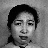

In [0]:
# We show how the library load our image
from tensorflow.keras.preprocessing import image
#This is an image from JAFFE dataset
img = image.load_img("/content/gdrive/My Drive/WeekSeven/KA.DI2.43.tiff", color_mode = "grayscale", target_size=(48, 48))
img

/tensorflow-2.1.0/python3.6/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


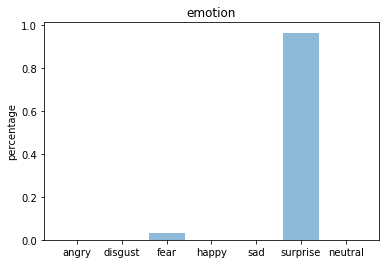

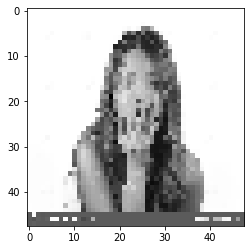

In [0]:
from tensorflow.keras.preprocessing import image
#Load google image downloader image
img = image.load_img("./downloads/asian female disgust face/5.portrait-young-shocked-surprised-beautiful-asian-korean-woman-covering-mouth-hand-disbelief-surprise-face-136248484.jpg", color_mode = "grayscale", target_size=(48, 48))
#Convert to array
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#Normalize
x /= 255
#Predict
custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

## Error Analysis

In [0]:
reload_model = tf.keras.models.load_model('/content/gdrive/My Drive/WeekSeven/emotiond.h5')
reload_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 22, 22, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 128)       147584    
_________________________________________________________________
average_pooling2d_2 (Average (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 10, 128)      

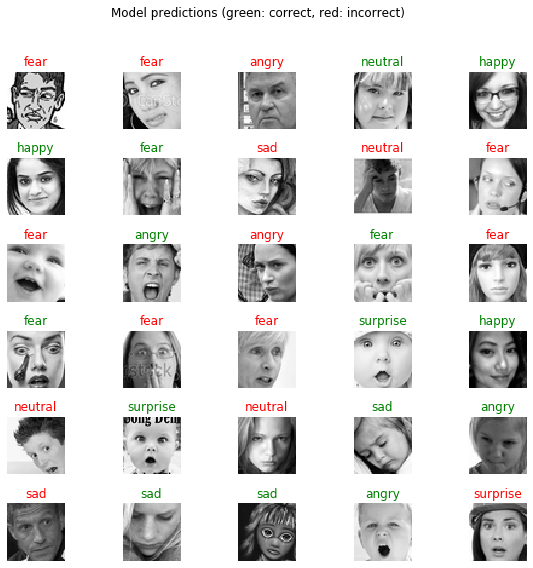

In [0]:
predicted_batch = reload_model.predict(x_test)
predicted_label_n = np.argmax(predicted_batch, axis=1)
predicted_label = [labels[idx] for idx in predicted_label_n]
# Plot the result

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.gray()
    plt.imshow(x_test[n].reshape([48, 48]))
    color = "green" if predicted_label_n[n] == Y_test[n] else "red"
    plt.title(predicted_label[n], color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

Functional API model

In [0]:
reload_model_hl = tf.keras.models.load_model('/content/gdrive/My Drive/My_CoderSchool/WeekSeven/Project/hog_landmark_sliding.h5')
reload_model_hl.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 48, 48, 64)   1664        img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 22, 22, 64)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 22, 22, 64)   256         max_pooling2d_2[0][0]            
____________________________________________________________________________________________

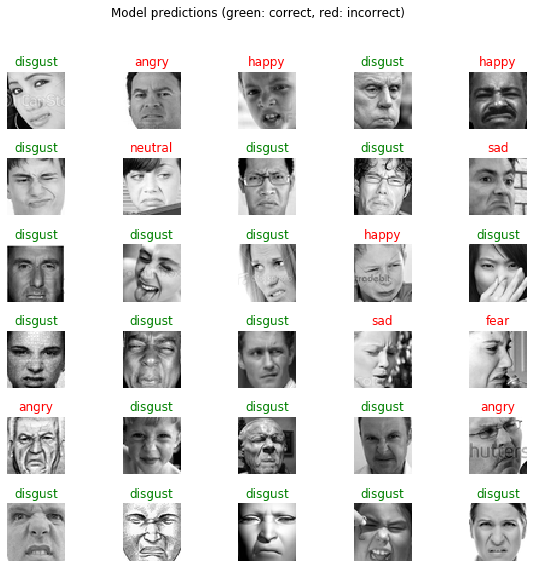

In [0]:
labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}

predicted_batch = reload_model_hl.predict({'img':val_dict['X'],'hog_landmark':val_dict['X2']})
predicted_label_n = np.argmax(predicted_batch, axis=1)
predicted_label = [labels[idx] for idx in predicted_label_n]
# Plot the result

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30,60):
    plt.subplot(6,5,n+1)
    plt.gray()
    plt.imshow(val_dict['X'][n].reshape([48, 48]))
    color = "green" if predicted_label_n[n] == Y_test_c[n] else "red"
    plt.title(predicted_label[n], color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# predicted_label_n[0]
# Y_test_c[0]